## **1) Evaluating Efficiency of Location Estimators**

For each of the location estimators we have considered -- mean (`np.mean`), median (`np.median`), mode  
(`mode2`; use a bin size of 50 km/s), Hodges-Lehmann mean (`hlmean`), 10% trimmed mean (`tmean`), and  
biweight mean (`biweight_location`), evaluate:

### **A) Efficiency of Each Estimator**
How efficient is each estimator, for a case with **ndata=100** and **foutlier=0**; i.e., compare the standard  
deviations of the value returned by the estimator, amongst all the simulations, for perfect Gaussian data.  

### **Which yields the most accurate results (with the smallest spread around the true value)?**

You do **not** need to actually calculate **ARE** here, just compare spreads (i.e., the standard deviation of the  
value from each location estimator) for each.

#### <span style="color:green;">***Mykola's Discussion:***</span>

<span style="color:green;">

The np.mean estimator yeilds the most accurate results becuase it has the smallest spread around the true mean value. 




</span>



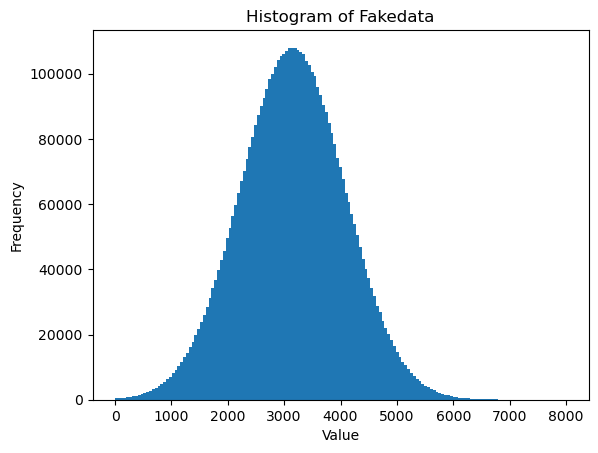

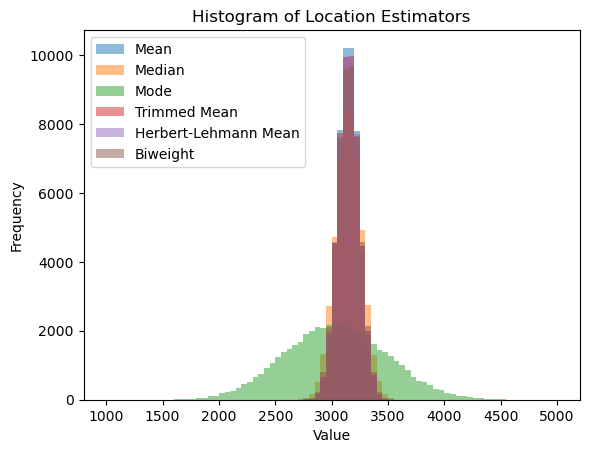

Mean spread:          92.8
Median spread:        115
Mode spread:          461
Trimmed mean spread:  95.3
HL mean spread:       95.6
Biweight spread:      98.9


In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import random  # Keep this only if you need functions like random.choice()
from astropy.stats import biweight_location

# ================================================================
# DEFININING FAKE DATA
# The Mean is 3150 (TRUE MEAN)
# Standard Deviation is 930 (TRUE STANDARD DEVIATION)
# Note: no outliers.
# Note: Perfect gaussian distribution.
# ================================================================

nsims = int(5E4)
ndata = 100
foutlier = 0 # 0.1 would be 10%

# Boolean array where True is an outlier at the frequency of foutlier
# if foutlier = 0, then there are no outliers and the whole array is false.
isoutlier = np.random.rand(nsims, ndata) < foutlier

fakedata = (1 - isoutlier) * (np.random.randn(nsims, ndata) * 930. + 3150) \
            + (isoutlier) * (np.random.randn(nsims, ndata) * 200. + 4750)  # Fix here

# ================================================================
# PLOTTING FAKE DATA HISTOGRAM
# ================================================================

plt.hist(fakedata.flatten(), bins=np.linspace(0, 8000, 160))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Fakedata')
plt.show()

# ================================================================
# DEFINING HLMEAN FUNCTION 
# ================================================================

def hlmean(data, nsamp=-1):
    # PURPOSE:
    #
    #  Calculate Hodges-Lehmann estimator of mean, using nsamp
    #   bootstraps from the data
    #
    # The Hodges-Lehmann estimator is, formally, the median value of
    #  (x_i+x_j)/2 over all pairs of indices i,j .
    # Here, we estimate that quantity using nsamp randomly chosen values
    # of i & j, rather than using all possible values.
    #
    # Although it has much of the robustness of an ordinary median, the
    # H-L estimator yields much smaller errors (equivalent to the mean of
    # >96% as much data, while the median has errors equivalent to the
    # standard error of 64% as much data).
    #
    # CALLING SEQUENCE:
    #
    #  result=hlmean(data [,nsamp=nsamp])
    #
    # INPUTS:
    #
    #  data: array of values to calculate the H-L mean of
    #
    # OPTIONAL KEYWORD PARAMETERS:
    #
    #  nsamp= : if set, hlmean will use this number of bootstrap
    #  samples to do the calculation.  If not set, it will use a number of random pairs equal to
    #  50 times the number of elements of the data array
    #
    # OUTPUTS:
    #
    #  result: sampling-derived estimate of the H-L mean estimator
    #
    # EXAMPLE:
    #    test=[1,2,0,1,2,20.]
    #    print hlmean(test)
    
    ndata=len(data)
    
    # if the number of samples has not been provided, set it to 50*the size of the data array
    
    if nsamp < 0:
        nsamp=50.*ndata
    nsamp=int(nsamp)

# create resampled version of original data
    newdata = np.random.choice(data,size=(nsamp,2))
    
    # average x1 + x2 from each random draw
    mn = (newdata[:,0]+newdata[:,1])/2.
    
    # calculate the median of the averages
    return(np.median(mn))

# ================================================================
# Defining mode2 Function
# ================================================================

def mode2(data,**kwargs):
# note: provide bins and (optionally) range keywords to not use
# defaults of np.histogram (10 bins, full range)
    counts,edges=np.histogram(data,**kwargs)
    whmax=np.argmax(counts)
    mode=(edges[whmax]+edges[whmax+1])/2
    return(mode)


# ================================================================
# COMPUTING LOCATION ESTIMATORS 
# Note: counts along axis=1 which is all the collumns
# We're doing an nsims computations for ndata points each
# ================================================================

data_means = np.mean(fakedata, axis=1)
data_medians = np.median(fakedata, axis=1)
data_modes = np.apply_along_axis(mode2, axis=1, arr=fakedata, bins=50)
data_tmeans = stats.trim_mean(fakedata, proportiontocut=0.1, axis=1)
data_hlmeans = np.apply_along_axis(hlmean, axis=1, arr=fakedata)
data_biweight = biweight_location(fakedata, axis=1)

plt.hist(data_means, bins=np.linspace(1000, 5000, 81), alpha=0.5, label='Mean')
plt.hist(data_medians, bins=np.linspace(1000, 5000, 81), alpha=0.5, label='Median')
plt.hist(data_modes, bins=np.linspace(1000, 5000, 81), alpha=0.5, label='Mode')
plt.hist(data_tmeans, bins=np.linspace(1000, 5000, 81), alpha=0.5, label='Trimmed Mean')
plt.hist(data_hlmeans, bins=np.linspace(1000, 5000, 81), alpha=0.5, label='Herbert-Lehmann Mean')
plt.hist(data_biweight, bins=np.linspace(1000, 5000, 81), alpha=0.5, label='Biweight')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Location Estimators')
plt.show()

# ================================================================
# COMPUTING SPREAD AROUND THE TRUE VALUE FORE EACH ESTIMATOR (MEAN SQUARE ERROR)
# ================================================================

spread_means = np.sqrt(np.mean((data_means - 3150)**2))
spread_medians = np.sqrt(np.mean((data_medians - 3150)**2))
spread_modes = np.sqrt(np.mean((data_modes - 3150)**2))
spread_tmeans = np.sqrt(np.mean((data_tmeans - 3150)**2))
spread_hlmeans = np.sqrt(np.mean((data_hlmeans - 3150)**2))
spread_biweight = np.sqrt(np.mean((data_biweight - 3150)**2))

print(f'Mean spread:          {spread_means:.3g}')
print(f'Median spread:        {spread_medians:.3g}')
print(f'Mode spread:          {spread_modes:.3g}')
print(f'Trimmed mean spread:  {spread_tmeans:.3g}')
print(f'HL mean spread:       {spread_hlmeans:.3g}')
print(f'Biweight spread:      {spread_biweight:.3g}')

## **B) Evaluating Bias and Spread of Each Estimator**

Now find the **bias** (i.e., average offset from true mean) and **spread** of each estimator, for:  
- **ndata = 10** (typical case for distant clusters)  
- **ndata = 100** (an ideal intensive-study case)  
- **foutlier = 0.1**  

### **Bias Calculation**
For bias, look at the **mean value** of:  
$
\text{estimated location} - 3150
$

### **Spread Calculation**
For spread, look at:  

np.std(estimated value)

### **Explain which estimator do you think we should use in each case, and why?**



#### <span style="color:green;">***Mykola's Discussion:***</span>

<span style="color:green;">

For N-Data = 10: 

I would use the Trimmed Mean estimator. This is because the Mean, Median, Trimmed Mean, HL Mean and Biweight all have the smae spread. But the median has the lowest bias. 

For N-Data = 100:  

I see that Mean, Median, HL mean, Trimmed mean, and biweight mean have lower, but still similar to each other spread. Hoewver, this time around I would choose Median  because of these low spread functions, it has the lowest bias. 

</span>


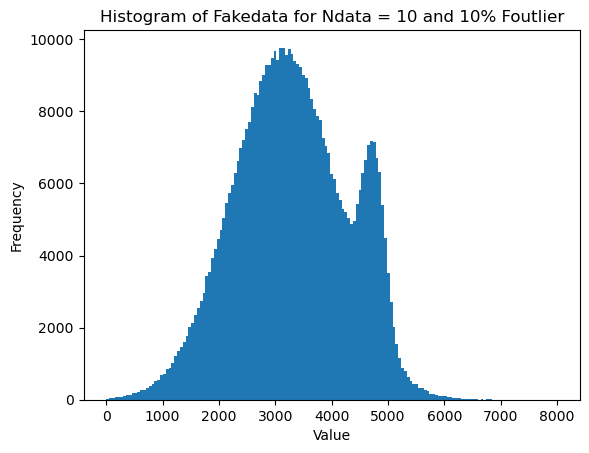

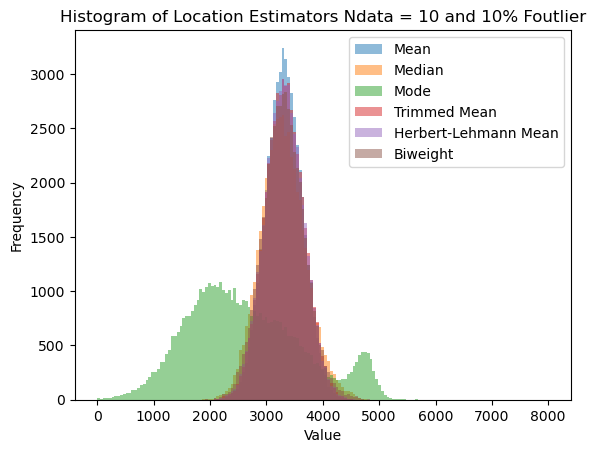


          BIAS FOR NDATA = 10 AND 10% FOUTLIER

Mean bias:       160.090
Median bias:     145.917
Mode bias:       -513.180
Trimmed mean bias: 165.580
HL mean bias:    161.606
Biweight bias:   155.057

          SPREAD FOR NDATA = 10 AND 10% FOUTLIER

Mean spread:       319.576
Median spread:     399.985
Mode spread:       1031.690
Trimmed mean spread: 340.857
HL mean spread:    341.509
Biweight spread:   369.346


In [ ]:
# ================================================================

# DEFININING FAKE DATA - FOR NDATA = 10, and 10% Foutlier
# The Mean is 3150 (TRUE MEAN)
# Standard Deviation is 930 (TRUE STANDARD DEVIATION)

# Outlier Mean is 4750
# Outlier Standard Deviation is 200
# Note: outliers present.
# Note: no longer gaussian distribution.

# ================================================================

nsims = int(5E4)
ndata = 10
foutlier = 0.1

# Boolean array where True is an outlier at the frequency of foutlier
# if foutlier = 0, then there are no outliers and the whole array is false.
isoutlier = np.random.rand(nsims, ndata) < foutlier

fakedata = (1 - isoutlier) * (np.random.randn(nsims, ndata) * 930. + 3150) \
            + (isoutlier) * (np.random.randn(nsims, ndata) * 200. + 4750)  # Fix here

# ================================================================
# PLOTTING FAKE DATA HISTOGRAM
# ================================================================

plt.hist(fakedata.flatten(), bins=np.linspace(0, 8000, 160))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Fakedata for Ndata = 10 and 10% Foutlier')
plt.show()


# ================================================================
# COMPUTING LOCATION ESTIMATORS 
# Note: counts along axis=1 which is all the collumns
# We're doing an nsims computations for ndata points each
# ================================================================

data_means = np.mean(fakedata, axis=1)
data_medians = np.median(fakedata, axis=1)
data_modes = np.apply_along_axis(mode2, axis=1, arr=fakedata, bins=50)
data_tmeans = stats.trim_mean(fakedata, proportiontocut=0.1, axis=1)
data_hlmeans = np.apply_along_axis(hlmean, axis=1, arr=fakedata)
data_biweight = biweight_location(fakedata, axis=1)

# ================================================================
# PLOTTING THE LOCATION ESTIMATORS
# ================================================================

plt.hist(data_means, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Mean')
plt.hist(data_medians, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Median')
plt.hist(data_modes, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Mode')
plt.hist(data_tmeans, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Trimmed Mean')
plt.hist(data_hlmeans, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Herbert-Lehmann Mean')
plt.hist(data_biweight, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Biweight')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Location Estimators Ndata = 10 and 10% Foutlier')
plt.show()

# ================================================================
# COMPUTING BIAS - NDATA = 10, 10% Foutlier
# ================================================================

bias_means = np.mean(data_means - 3150)
bias_medians = np.mean(data_medians - 3150)
bias_modes = np.mean(data_modes - 3150)
bias_tmeans = np.mean(data_tmeans - 3150)
bias_hlmeans = np.mean(data_hlmeans - 3150)
bias_biweight = np.mean(data_biweight - 3150)

print()
print("=" * 60)
print(" " * 10 + "BIAS FOR NDATA = 10 AND 10% FOUTLIER")
print("=" * 60)
print()

print(f'Mean bias:       {bias_means:.3f}')
print(f'Median bias:     {bias_medians:.3f}')
print(f'Mode bias:       {bias_modes:.3f}')
print(f'Trimmed mean bias: {bias_tmeans:.3f}')
print(f'HL mean bias:    {bias_hlmeans:.3f}')
print(f'Biweight bias:   {bias_biweight:.3f}')

# ================================================================
# COMPUTING SPREAD - NDATA = 10, 10% Foutlier
# ================================================================

spread_means = np.std(data_means)
spread_medians = np.std(data_medians)
spread_modes = np.std(data_modes)
spread_tmeans = np.std(data_tmeans)
spread_hlmeans = np.std(data_hlmeans)
spread_biweight = np.std(data_biweight)


print()
print("=" * 60)
print(" " * 10 + "SPREAD FOR NDATA = 10 AND 10% FOUTLIER")
print("=" * 60)
print()

print(f'Mean spread:       {spread_means:.3f}')
print(f'Median spread:     {spread_medians:.3f}')
print(f'Mode spread:       {spread_modes:.3f}')
print(f'Trimmed mean spread: {spread_tmeans:.3f}')
print(f'HL mean spread:    {spread_hlmeans:.3f}')
print(f'Biweight spread:   {spread_biweight:.3f}')


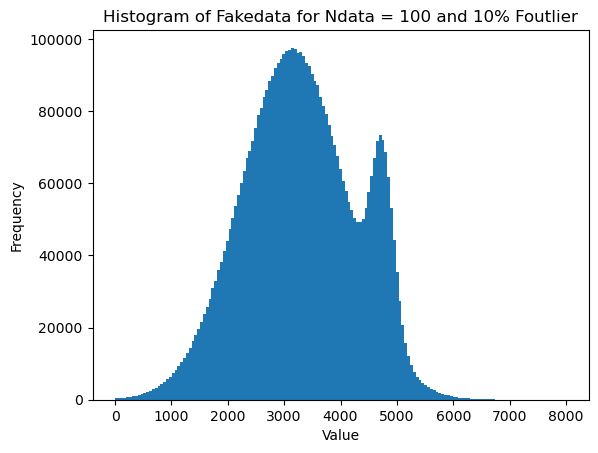

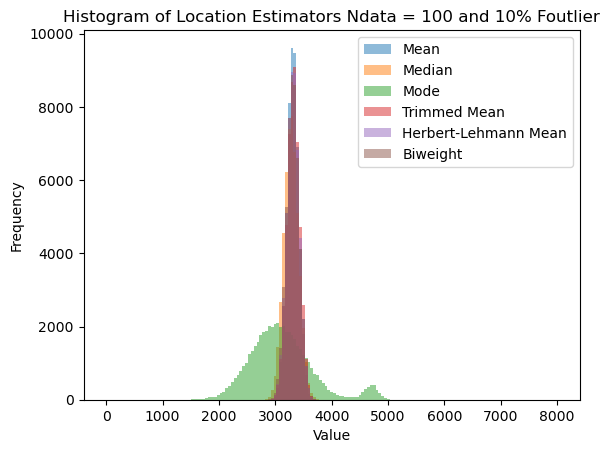


          BIAS FOR NDATA = 100 AND 10% FOUTLIER

Mean bias:       161.071
Median bias:     132.641
Mode bias:       -31.383
Trimmed mean bias: 170.601
HL mean bias:    163.247
Biweight bias:   158.423

          SPREAD FOR NDATA = 100 AND 10% FOUTLIER

Mean spread:        100.415
Median spread:      129.980
Mode spread:        571.571
Trimmed mean spread:109.379
HL mean spread:     107.845
Biweight spread:    111.038


In [10]:
# ================================================================

# DEFININING FAKE DATA - FOR NDATA = 100, and 10% Foutlier
# The Mean is 3150 (TRUE MEAN)
# Standard Deviation is 930 (TRUE STANDARD DEVIATION)

# Outlier Mean is 4750
# Outlier Standard Deviation is 200
# Note: no outliers
# Note: no longer gaussian distribution.


# ================================================================

nsims = int(5E4)
ndata = 100
foutlier = 0.1

# Boolean array where True is an outlier at the frequency of foutlier
# if foutlier = 0, then there are no outliers and the whole array is false.
isoutlier = np.random.rand(nsims, ndata) < foutlier

fakedata = (1 - isoutlier) * (np.random.randn(nsims, ndata) * 930. + 3150) \
            + (isoutlier) * (np.random.randn(nsims, ndata) * 200. + 4750)  # Fix here

# ================================================================
# PLOTTING FAKE DATA HISTOGRAM
# ================================================================

plt.hist(fakedata.flatten(), bins=np.linspace(0, 8000, 160))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Fakedata for Ndata = 100 and 10% Foutlier')
plt.show()

# ================================================================
# COMPUTING LOCATION ESTIMATORS 
# Note: counts along axis=1 which is all the collumns
# We're doing an nsims computations for ndata points each
# ================================================================

data_means = np.mean(fakedata, axis=1)
data_medians = np.median(fakedata, axis=1)
data_modes = np.apply_along_axis(mode2, axis=1, arr=fakedata, bins=50)
data_tmeans = stats.trim_mean(fakedata, proportiontocut=0.1, axis=1)
data_hlmeans = np.apply_along_axis(hlmean, axis=1, arr=fakedata)
data_biweight = biweight_location(fakedata, axis=1)

# ================================================================
# PLOTTING THE LOCATION ESTIMATORS
# ================================================================

plt.hist(data_means, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Mean')
plt.hist(data_medians, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Median')
plt.hist(data_modes, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Mode')
plt.hist(data_tmeans, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Trimmed Mean')
plt.hist(data_hlmeans, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Herbert-Lehmann Mean')
plt.hist(data_biweight, bins=np.linspace(0, 8000, 160), alpha=0.5, label='Biweight')
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Location Estimators Ndata = 100 and 10% Foutlier')
plt.show()

# ================================================================
# COMPUTING BIAS - NDATA = 100, 10% Foutlier
# ================================================================

bias_means = np.mean(data_means - 3150)
bias_medians = np.mean(data_medians - 3150)
bias_modes = np.mean(data_modes - 3150)
bias_tmeans = np.mean(data_tmeans - 3150)
bias_hlmeans = np.mean(data_hlmeans - 3150)
bias_biweight = np.mean(data_biweight - 3150)

print()
print("=" * 60)
print(" " * 10 + "BIAS FOR NDATA = 100 AND 10% FOUTLIER")
print("=" * 60)
print()

print(f'Mean bias:       {bias_means:.3f}')
print(f'Median bias:     {bias_medians:.3f}')
print(f'Mode bias:       {bias_modes:.3f}')
print(f'Trimmed mean bias: {bias_tmeans:.3f}')
print(f'HL mean bias:    {bias_hlmeans:.3f}')
print(f'Biweight bias:   {bias_biweight:.3f}')

# ================================================================
# COMPUTING SPREAD - NDATA = 100, 10% Foutlier
# ================================================================

spread_means = np.std(data_means)
spread_medians = np.std(data_medians)
spread_modes = np.std(data_modes)
spread_tmeans = np.std(data_tmeans)
spread_hlmeans = np.std(data_hlmeans)
spread_biweight = np.std(data_biweight)


print()
print("=" * 60)
print(" " * 10 + "SPREAD FOR NDATA = 100 AND 10% FOUTLIER")
print("=" * 60)
print()

print(f'Mean spread:        {spread_means:.3f}')
print(f'Median spread:      {spread_medians:.3f}')
print(f'Mode spread:        {spread_modes:.3f}')
print(f'Trimmed mean spread:{spread_tmeans:.3f}')
print(f'HL mean spread:     {spread_hlmeans:.3f}')
print(f'Biweight spread:    {spread_biweight:.3f}')



## 2) Simulations for Velocity Dispersion Estimation

Set up simulations for a slightly different case: now assume outliers have a uniformly-distributed velocity between 0 and 6500 km/sec, and that we want to measure the velocity dispersion, rather than the mean velocity, of the cluster. We have a variety of estimators for dispersion: 

- Sample standard deviation (`np.std`)
- Average absolute deviation (which we implemented)
- MAD (`median_abs_deviation`)
- Biweight standard deviation (`biweight_scale`)
- IQR (implemented by you)
- 10% trimmed standard deviation (using `scipy.stats.tstd`)

### Evaluation:

**A)** The efficiency of each estimator, with `ndata=100` and `foutlier=0`; i.e., compare the standard deviations of the value returned by the estimator, amongst all the simulations, for perfect Gaussian data. 

### **Which yields the most accurate results (with the smallest spread around the true value, i.e. smallest $\langle (\text{estimated} - \text{true})^2 \rangle$)?**

Remember to apply the normalization corrections to get the equivalent of a Gaussian $\sigma$ from non-standard deviation measures like MAD before comparing.

#### <span style="color:green;">***Mykola's Discussion:***</span>

<span style="color:green;">

The smallest spread aroudn teh true value (i.e. the smallest Mean Squared Error) is deliverd by the Standard Deviation Estimator.


</span>

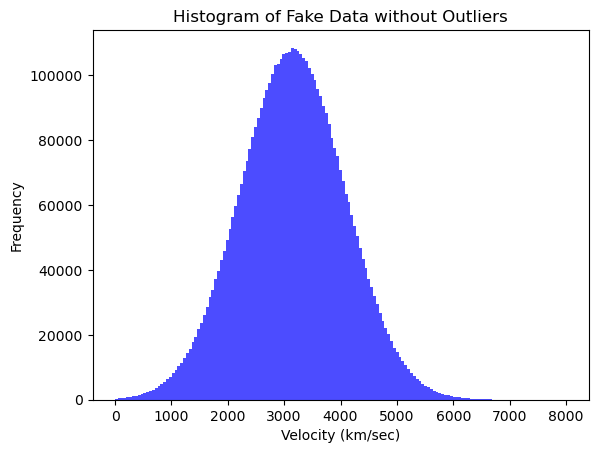

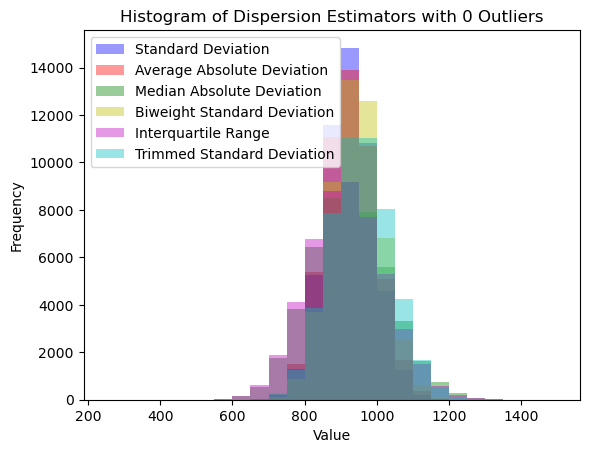


          SANDARD DEVIATION OF ESTIMATORS WITH 0 OUTLIERS

Standard Deviation of Standard Deviation Estimator:        66
Standard Deviation of Average Absolute Deviation Estimator: 70.6
Standard Deviation of Median Absolute Deviation Estimator:  108
Standard Deviation of Biweight Standard Deviation Estimator: 70.3
Standard Deviation of Interquartile Range Estimator:        107
Standard Deviation of Trimmed Standard Deviation Estimator: 85.4

Mean Squared Error of Estimators as Compared to True Value of 930 km/sec

Mean Squared Error of Standard Deviation Estimator:        66.4
Mean Squared Error of Average Absolute Deviation Estimator: 70.8
Mean Squared Error of Median Absolute Deviation Estimator:  108
Mean Squared Error of Biweight Standard Deviation Estimator: 71.3
Mean Squared Error of Interquartile Range Estimator:        108
Mean Squared Error of Trimmed Standard Deviation Estimator: 88.9


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import astropy

# ================================================================
# DEFINING FAKE DATA - FOR NDATA = 100, and NO OOUTLER
# The Mean is 3150 (TRUE MEAN)
# Standard Deviation is 930 (TRUE STANDARD DEVIATION)

# Outliers are now uniformly distributed between 0 and 6500 km/sec.
# ================================================================

nsims = int(5E4)
ndata = 100
foutlier = 0 # 0.1 would be 10%

isoutlier = np.random.rand(nsims, ndata) < foutlier

fakedata = (np.random.randn(nsims, ndata) * 930. + 3150) # No outlier no problem.

# # Boolean array where True represents an outlier at the frequency of foutlier
# isoutlier = np.random.rand(nsims, ndata) < foutlier

# # Generate non-outlier data from a Gaussian distribution
# normal_data = np.random.randn(nsims, ndata) * 930. + 3150

# # Generate outlier data from a uniform distribution between 0 and 6500 km/sec
# outlier_data = np.random.uniform(0, 6500, size=(nsims, ndata))

# # Combine the two datasets: use normal_data where isoutlier is False, outlier_data where True
# fakedata = np.where(isoutlier, outlier_data, normal_data)

# ================================================================
# PLOTTING FAKE DATA HISTOGRAM
# ================================================================

plt.hist(fakedata.flatten(), bins=np.linspace(0, 8000, 160), alpha=0.7, color='b')
plt.xlabel('Velocity (km/sec)')
plt.ylabel('Frequency')
plt.title('Histogram of Fake Data without Outliers')
plt.show()


# ================================================================
# COMPUTE DISPERSION ESTIMATORS
# ================================================================

fakedata_std = np.std(fakedata, axis=1) 
fakedata_aad = np.mean(np.abs(fakedata - fakedata.mean(axis=1, keepdims=True)), axis=1) / 0.7979
fakedata_mad = stats.median_abs_deviation(fakedata, axis=1, scale = 'normal')
fakedata_biweght = np.sqrt(astropy.stats.biweight_midvariance(fakedata, axis=1)) / 0.99
fakedata_iqr = stats.iqr(fakedata, axis=1) / 1.349

# Compute 10% trimmed standard deviation
# Need to multiply this by 1.548 to get the estimate of standard deviation
fakedata_trimmed_std = scipy.stats.mstats.trimmed_std(fakedata, limits=(0.1, 0.1), axis=1) * 1.548


# ================================================================
# PLOT DISPERSION ESTIMATORS
# ================================================================
plt.hist(fakedata_std, bins=np.linspace(250, 1500, 26), alpha=0.4, color='b', label='Standard Deviation')
plt.hist(fakedata_aad, bins=np.linspace(250, 1500, 26), alpha=0.4, color='r', label='Average Absolute Deviation')
plt.hist(fakedata_mad, bins=np.linspace(250, 1500, 26), alpha=0.4, color='g', label='Median Absolute Deviation')
plt.hist(fakedata_biweght, bins=np.linspace(250, 1500, 26), alpha=0.4, color='y', label='Biweight Standard Deviation')
plt.hist(fakedata_iqr, bins=np.linspace(250, 1500, 26), alpha=0.4, color='m', label='Interquartile Range')
plt.hist(fakedata_trimmed_std, bins=np.linspace(250, 1500, 26), alpha=0.4, color='c', label='Trimmed Standard Deviation')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Dispersion Estimators with 0 Outliers')
plt.legend()
plt.show()

# ================================================================
# COMPUTING THE STANDARD DEVIATION OF THE ESTIMATORS WITH 0 OUTLIERS
# ================================================================

std_fakedata_std = np.std(fakedata_std)
std_fakedata_aad = np.std(fakedata_aad)
std_fakedata_mad = np.std(fakedata_mad)
std_fakedata_biweght = np.std(fakedata_biweght)
std_fakedata_iqr = np.std(fakedata_iqr)
std_fakedata_trimmed_std = np.std(fakedata_trimmed_std)

print()
print("=" * 60)
print(" " * 10 + "SANDARD DEVIATION OF ESTIMATORS WITH 0 OUTLIERS")
print("=" * 60)
print()

print('Standard Deviation of Standard Deviation Estimator:       ', f"{std_fakedata_std:.3g}")
print('Standard Deviation of Average Absolute Deviation Estimator:', f"{std_fakedata_aad:.3g}")
print('Standard Deviation of Median Absolute Deviation Estimator: ', f"{std_fakedata_mad:.3g}")
print('Standard Deviation of Biweight Standard Deviation Estimator:', f"{std_fakedata_biweght:.3g}")
print('Standard Deviation of Interquartile Range Estimator:       ', f"{std_fakedata_iqr:.3g}")
print('Standard Deviation of Trimmed Standard Deviation Estimator:', f"{std_fakedata_trimmed_std:.3g}")

# ================================================================
# COMPUTING SPREAD AROUND THE TRUE VALUE
#  Which yields the most accurate results (with the smallest spread around the true value, i.e. smallest
# <(estimated - true)2>)?
# ================================================================

real_std = 930  # Given in problem statement and defined in fake data above

# Compute Mean Squared Error for each estimator
mse_fakedata_std = np.sqrt(np.mean((fakedata_std - real_std) ** 2))
mse_fakedata_aad = np.sqrt(np.mean((fakedata_aad - real_std) ** 2))
mse_fakedata_mad = np.sqrt(np.mean((fakedata_mad - real_std) ** 2))
mse_fakedata_biweght = np.sqrt(np.mean((fakedata_biweght - real_std) ** 2))
mse_fakedata_iqr = np.sqrt(np.mean((fakedata_iqr - real_std) ** 2))
mse_fakedata_trimmed_std = np.sqrt(np.mean((fakedata_trimmed_std - real_std) ** 2))

print()
print("=" * 60)
print("Mean Squared Error of Estimators as Compared to True Value of 930 km/sec")
print("=" * 60)
print()

print('Mean Squared Error of Standard Deviation Estimator:       ', f"{mse_fakedata_std:.3g}")
print('Mean Squared Error of Average Absolute Deviation Estimator:', f"{mse_fakedata_aad:.3g}")
print('Mean Squared Error of Median Absolute Deviation Estimator: ', f"{mse_fakedata_mad:.3g}")
print('Mean Squared Error of Biweight Standard Deviation Estimator:', f"{mse_fakedata_biweght:.3g}")
print('Mean Squared Error of Interquartile Range Estimator:       ', f"{mse_fakedata_iqr:.3g}")
print('Mean Squared Error of Trimmed Standard Deviation Estimator:', f"{mse_fakedata_trimmed_std:.3g}")



## **Problem 2 Part B:  Evaluate Both the Spread and Bias of Each Estimator**

Evaluate both the spread and bias of each estimator (comparing to the correct value of 930), for  
**ndata = 10** (typical high-z case) and **ndata = 100** (ideal intensive-study case), with **foutlier = 0.1**.  

Explain which estimator do you think we should use in each case, and why?


#### <span style="color:green;">***Mykola's Discussion:***</span>

<span style="color:green;">

For Ndata = 10: 

I would use the median aboslute deviation estimator becuase it has the lowest bias but a spread comprabale to all of the other estimators (~200-250 range).

FOr Ndata = 100:

I would sie the IQR estimator because it has the lowest bias but still a comprable spread to all the other estimators (~80 to 120)

</span>

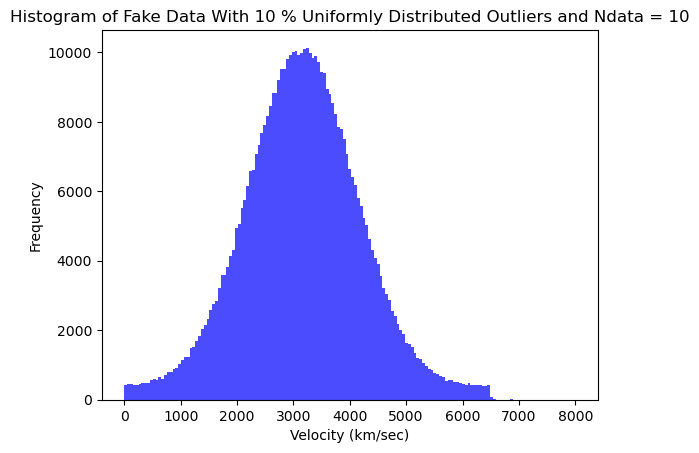

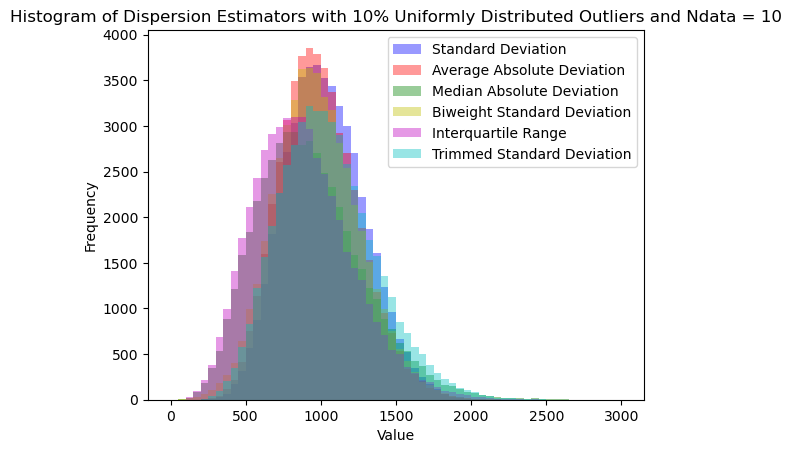


BIAS OF ESTIMATORS AS COMPARED TO TRUE VALUE (930) FOR NDATA = 10 AND 10% UNIFORMLY DISTRIBUTED OUTLIER

Bias of Standard Deviation Estimator:           98.718
Bias of Average Absolute Deviation Estimator:   60.794
Bias of Median Absolute Deviation Estimator:    -2.177
Bias of Biweight Estimator:                     46.271
Bias of Interquartile Range Estimator:          -50.318
Bias of Trimmed Standard Deviation Estimator:   113.523

SPREAD OF ESTIMATORS FOR NDATA = 10 AND 10% UNIFORMLY DISTRIBUTED OUTLIER

Spread of Standard Deviation Estimator:           264.408
Spread of Average Absolute Deviation Estimator:   261.507
Spread of Median Absolute Deviation Estimator:    351.893
Spread of Biweight Estimator:                     280.534
Spread of Interquartile Range Estimator:          325.401
Spread of Trimmed Standard Deviation Estimator:   319.281


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import astropy
from astropy.stats import biweight_midvariance

# ================================================================
# DEFINING FAKE DATA - FOR NDATA = 10, and 10 % Outliers
# The Mean is 3150 (TRUE MEAN)
# Standard Deviation is 930 (TRUE STANDARD DEVIATION)

# Outliers are now uniformly distributed between 0 and 6500 km/sec.
# ================================================================

nsims = int(5E4)
ndata = 10
foutlier = 0.1 # 0.1 would be 10%

isoutlier = np.random.rand(nsims, ndata) < foutlier

fakedata = (1 - isoutlier) * (np.random.randn(nsims, ndata) * 930. + 3150) \
            + (isoutlier) * (np.random.rand(nsims, ndata) * 6500)  # Note: rand is a uniform dist.


# ================================================================
# PLOTTING FAKE DATA HISTOGRAM
# ================================================================

plt.hist(fakedata.flatten(), bins=np.linspace(0, 8000, 160), alpha=0.7, color='b')
plt.xlabel('Velocity (km/sec)')
plt.ylabel('Frequency')
plt.title('Histogram of Fake Data With 10 % Uniformly Distributed Outliers and Ndata = 10')
plt.show()


# ================================================================
# COMPUTE DISPERSION ESTIMATORS
# ================================================================

fakedata_std = np.std(fakedata, axis=1, ddof = 1) 
fakedata_aad = np.mean(np.abs(fakedata - fakedata.mean(axis=1, keepdims=True)), axis=1) / 0.7979
fakedata_mad = stats.median_abs_deviation(fakedata, axis=1, scale = 'normal')
fakedata_biweght = np.sqrt(biweight_midvariance(fakedata, axis=1)) / 0.99
fakedata_iqr = stats.iqr(fakedata, axis=1) / 1.349

# Compute 10% trimmed standard deviation
# Need to multiply this by 1.548 to get the estimate of standard deviation
fakedata_trimmed_std = scipy.stats.mstats.trimmed_std(fakedata, limits=(0.1, 0.1), axis=1) * 1.548


# ================================================================
# PLOT DISPERSION ESTIMATORS
# ================================================================
plt.hist(fakedata_std, bins=np.linspace(0, 3000, 61), alpha=0.4, color='b', label='Standard Deviation')
plt.hist(fakedata_aad, bins=np.linspace(0, 3000, 61), alpha=0.4, color='r', label='Average Absolute Deviation')
plt.hist(fakedata_mad, bins=np.linspace(0, 3000, 61), alpha=0.4, color='g', label='Median Absolute Deviation')
plt.hist(fakedata_biweght, bins=np.linspace(0, 3000, 61), alpha=0.4, color='y', label='Biweight Standard Deviation')
plt.hist(fakedata_iqr, bins=np.linspace(0, 3000, 61), alpha=0.4, color='m', label='Interquartile Range')
plt.hist(fakedata_trimmed_std, bins=np.linspace(0, 3000, 61), alpha=0.4, color='c', label='Trimmed Standard Deviation')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Dispersion Estimators with 10% Uniformly Distributed Outliers and Ndata = 10')
plt.legend()
plt.show()


# ================================================================
# COMPUTING BIAS - NDATA = 10, 10% Foutlier
# ================================================================

bias_std = np.mean(fakedata_std - 930)
bias_aad = np.mean(fakedata_aad - 930)
bias_mad = np.mean(fakedata_mad - 930)
bias_biweght = np.mean(fakedata_biweght - 930)
bias_iqr = np.mean(fakedata_iqr - 930)
bias_trimmed_std = np.mean(fakedata_trimmed_std - 930)

print()
print("=" * 60)
print("BIAS OF ESTIMATORS AS COMPARED TO TRUE VALUE (930) FOR NDATA = 10 AND 10% UNIFORMLY DISTRIBUTED OUTLIER")
print("=" * 60)
print()

print('Bias of Standard Deviation Estimator:          ', round(bias_std, 3))
print('Bias of Average Absolute Deviation Estimator:  ', round(bias_aad, 3))
print('Bias of Median Absolute Deviation Estimator:   ', round(bias_mad, 3))
print('Bias of Biweight Estimator:                    ', round(bias_biweght, 3))
print('Bias of Interquartile Range Estimator:         ', round(bias_iqr, 3))
print('Bias of Trimmed Standard Deviation Estimator:  ', round(bias_trimmed_std, 3))

# ================================================================
# COMPUTING SPREAD - NDATA = 10, 10% Foutlier
# ================================================================

spread_std = np.std(fakedata_std)
spread_aad = np.std(fakedata_aad)
spread_mad = np.std(fakedata_mad)
spread_biweght = np.std(fakedata_biweght)
spread_iqr = np.std(fakedata_iqr)
spread_trimmed_std = np.std(fakedata_trimmed_std)

print()
print("=" * 60)
print("SPREAD OF ESTIMATORS FOR NDATA = 10 AND 10% UNIFORMLY DISTRIBUTED OUTLIER")
print("=" * 60)
print()

print("Spread of Standard Deviation Estimator:          ", round(spread_std, 3))
print("Spread of Average Absolute Deviation Estimator:  ", round(spread_aad, 3))
print("Spread of Median Absolute Deviation Estimator:   ", round(spread_mad, 3))
print("Spread of Biweight Estimator:                    ", round(spread_biweght, 3))
print("Spread of Interquartile Range Estimator:         ", round(spread_iqr, 3))
print("Spread of Trimmed Standard Deviation Estimator:  ", round(spread_trimmed_std, 3))


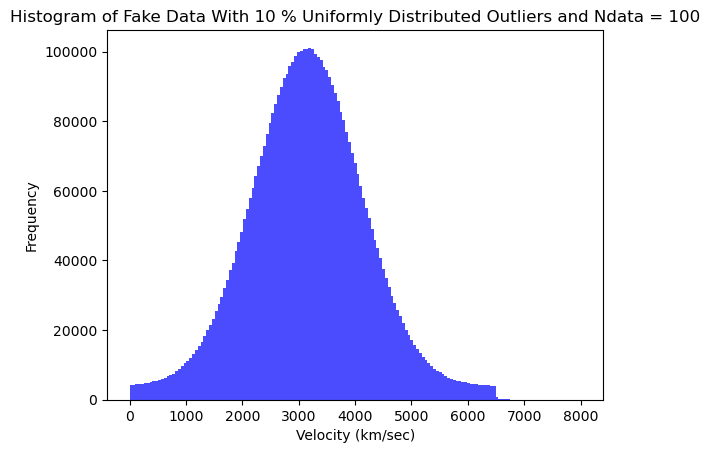

AttributeError: module 'astropy' has no attribute 'stats'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import astropy

# ================================================================
# DEFINING FAKE DATA - FOR NDATA = 10, and 10 % Outliers
# The Mean is 3150 (TRUE MEAN)
# Standard Deviation is 930 (TRUE STANDARD DEVIATION)

# Outliers are now uniformly distributed between 0 and 6500 km/sec.
# ================================================================

nsims = int(5E4)
ndata = 100
foutlier = 0.1 # 0.1 would be 10%

isoutlier = np.random.rand(nsims, ndata) < foutlier

fakedata = (1 - isoutlier) * (np.random.randn(nsims, ndata) * 930. + 3150) \
            + (isoutlier) * (np.random.rand(nsims, ndata) * 6500)  # Fix here

# # Boolean array where True represents an outlier at the frequency of foutlier
# isoutlier = np.random.rand(nsims, ndata) < foutlier

# # Generate non-outlier data from a Gaussian distribution
# normal_data = np.random.randn(nsims, ndata) * 930. + 3150

# # Generate outlier data from a uniform distribution between 0 and 6500 km/sec
# outlier_data = np.random.uniform(0, 6500, size=(nsims, ndata))

# # Combine the two datasets: use normal_data where isoutlier is False, outlier_data where True
# fakedata = np.where(isoutlier, outlier_data, normal_data)

# ================================================================
# PLOTTING FAKE DATA HISTOGRAM
# ================================================================

plt.hist(fakedata.flatten(), bins=np.linspace(0, 8000, 160), alpha=0.7, color='b')
plt.xlabel('Velocity (km/sec)')
plt.ylabel('Frequency')
plt.title('Histogram of Fake Data With 10 % Uniformly Distributed Outliers and Ndata = 100')
plt.show()


# ================================================================
# COMPUTE DISPERSION ESTIMATORS
# ================================================================

fakedata_std = np.std(fakedata, axis=1, ddof = 1) 
fakedata_aad = np.mean(np.abs(fakedata - fakedata.mean(axis=1, keepdims=True)), axis=1) / 0.7979
fakedata_mad = stats.median_abs_deviation(fakedata, axis=1, scale = 'normal')
fakedata_biweght = np.sqrt(astropy.stats.biweight_midvariance(fakedata, axis=1)) / 0.99
fakedata_iqr = stats.iqr(fakedata, axis=1) / 1.349

# Compute 10% trimmed standard deviation
# Need to multiply this by 1.548 to get the estimate of standard deviation
fakedata_trimmed_std = scipy.stats.mstats.trimmed_std(fakedata, limits=(0.1, 0.1), axis=1) * 1.548


# ================================================================
# PLOT DISPERSION ESTIMATORS
# ================================================================
plt.hist(fakedata_std, bins=np.linspace(500, 2000, 160), alpha=0.4, color='b', label='Standard Deviation')
plt.hist(fakedata_aad, bins=np.linspace(500, 2000, 160), alpha=0.4, color='r', label='Average Absolute Deviation')
plt.hist(fakedata_mad, bins=np.linspace(500, 2000, 160), alpha=0.4, color='g', label='Median Absolute Deviation')
plt.hist(fakedata_biweght, bins=np.linspace(500, 2000, 160), alpha=0.4, color='y', label='Biweight Standard Deviation')
plt.hist(fakedata_iqr, bins=np.linspace(500, 2000, 160), alpha=0.4, color='m', label='Interquartile Range')
plt.hist(fakedata_trimmed_std, bins=np.linspace(500, 2000, 160), alpha=0.4, color='c', label='Trimmed Standard Deviation')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Dispersion Estimators with 10% Uniformly Distributed Outliers and Ndata = 100')
plt.legend()
plt.show()


# ================================================================
# COMPUTING BIAS - NDATA = 10, 10% Foutlier
# ================================================================

bias_std = np.mean(fakedata_std - 930)
bias_aad = np.mean(fakedata_aad - 930)
bias_mad = np.mean(fakedata_mad - 930)
bias_biweght = np.mean(fakedata_biweght - 930)
bias_iqr = np.mean(fakedata_iqr - 930)
bias_trimmed_std = np.mean(fakedata_trimmed_std - 930)

print()
print("=" * 60)
print("BIAS OF ESTIMATORS AS COMPARED TO TRUE VALUE (930) FOR NDATA = 100 AND 10% UNIFORMLY DISTRIBUTED OUTLIER")
print("=" * 60)
print()

print('Bias of Standard Deviation Estimator:          ', round(bias_std, 3))
print('Bias of Average Absolute Deviation Estimator:  ', round(bias_aad, 3))
print('Bias of Median Absolute Deviation Estimator:   ', round(bias_mad, 3))
print('Bias of Biweight Estimator:                    ', round(bias_biweght, 3))
print('Bias of Interquartile Range Estimator:         ', round(bias_iqr, 3))
print('Bias of Trimmed Standard Deviation Estimator:  ', round(bias_trimmed_std, 3))

# ================================================================
# COMPUTING SPREAD - NDATA = 10, 10% Foutlier
# ================================================================

spread_std = np.std(fakedata_std)
spread_aad = np.std(fakedata_aad)
spread_mad = np.std(fakedata_mad)
spread_biweght = np.std(fakedata_biweght)
spread_iqr = np.std(fakedata_iqr)
spread_trimmed_std = np.std(fakedata_trimmed_std)

print()
print("=" * 60)
print("SPREAD OF ESTIMATORS FOR NDATA = 100 AND 10% UNIFORMLY DISTRIBUTED OUTLIER")
print("=" * 60)
print()

print("Spread of Standard Deviation Estimator:          ", round(spread_std, 3))
print("Spread of Average Absolute Deviation Estimator:  ", round(spread_aad, 3))
print("Spread of Median Absolute Deviation Estimator:   ", round(spread_mad, 3))
print("Spread of Biweight Estimator:                    ", round(spread_biweght, 3))
print("Spread of Interquartile Range Estimator:         ", round(spread_iqr, 3))
print("Spread of Trimmed Standard Deviation Estimator:  ", round(spread_trimmed_std, 3))
